In [1]:
!pip install ultralytics
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.6 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.1 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existin

In [2]:
from datasets import load_dataset
from PIL import Image
import os
import json
from tqdm import tqdm

# Load dataset dari Hugging Face
train_dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
val_dataset = load_dataset("naver-clova-ix/cord-v2", split="validation")

# Label map
label_map = {'table': 0, 'not_table': 1}

# Folder struktur YOLOv8
base_dir = "/kaggle/working/yolo_dataset"
for split in ['train', 'val']:
    os.makedirs(f"{base_dir}/images/{split}", exist_ok=True)
    os.makedirs(f"{base_dir}/labels/{split}", exist_ok=True)

# Fungsi konversi quadrilateral ke YOLO format
def quad_to_yolo(quad, img_w, img_h):
    x_coords = [quad[f'x{i}'] for i in range(1, 5)]
    y_coords = [quad[f'y{i}'] for i in range(1, 5)]
    x_min, x_max = min(x_coords), max(x_coords)
    y_min, y_max = min(y_coords), max(y_coords)

    x_center = (x_min + x_max) / 2.0 / img_w
    y_center = (y_min + y_max) / 2.0 / img_h
    width = (x_max - x_min) / img_w
    height = (y_max - y_min) / img_h

    return x_center, y_center, width, height

# Label map baru
label_map = {'table': 0, 'not_table': 1}

def save_yolo_data(dataset, split):
    image_dir = os.path.join(base_dir, 'images', split)
    label_dir = os.path.join(base_dir, 'labels', split)

    for i, example in tqdm(enumerate(dataset), total=len(dataset), desc=f"Converting {split}"):
        parsed = json.loads(example['ground_truth'])
        gt_parse = parsed.get('gt_parse', {})
        image = example['image']
        img_w, img_h = image.size

        img_path = os.path.join(image_dir, f"{split}_{i:06d}.jpg")
        label_path = os.path.join(label_dir, f"{split}_{i:06d}.txt")
        image.save(img_path, format="JPEG")

        all_x, all_y = [], []

        # Kumpulkan semua koordinat quad dari item_name, quantity, price
        for item in gt_parse.get('menu', []):
            if not isinstance(item, dict):
                continue  # skip item yang bukan dict (kadang bisa berupa string/null)

            item_name = item.get('nm', '')
            if isinstance(item_name, list):
                item_name = item_name[1] if len(item_name) > 1 else item_name[0] if item_name else ''
            item_name = str(item_name).strip().lower()

            quantity = str(item.get('cnt', '')).strip().lower()
            price = str(item.get('price', '')).strip().lower()

            for line in parsed.get('valid_line', []):
                words = line.get('words', [])
                text = ' '.join([w.get('text', '') for w in words]).strip().lower()

                if text in [item_name, quantity, price]:
                    for w in words:
                        if 'quad' in w:
                            for j in range(1, 5):
                                all_x.append(w['quad'][f'x{j}'])
                                all_y.append(w['quad'][f'y{j}'])

        # Jika ada koordinat, gabungkan menjadi satu bbox besar
        if all_x and all_y:
            merged_quad = {
                'x1': min(all_x), 'y1': min(all_y),
                'x2': max(all_x), 'y2': min(all_y),
                'x3': max(all_x), 'y3': max(all_y),
                'x4': min(all_x), 'y4': max(all_y),
            }

            x_c, y_c, w, h = quad_to_yolo(merged_quad, img_w, img_h)
            yolo_line = f"{label_map['table']} {x_c:.6f} {y_c:.6f} {w:.6f} {h:.6f}"

            with open(label_path, "w") as f:
                f.write(yolo_line)
        else:
            open(label_path, "w").close()

# Jalankan untuk train dan val
save_yolo_data(train_dataset, "train")
save_yolo_data(val_dataset, "val")

README.md:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

(…)-00000-of-00004-b4aaeceff1d90ecb.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

(…)-00001-of-00004-7dbbe248962764c5.parquet:   0%|          | 0.00/441M [00:00<?, ?B/s]

(…)-00002-of-00004-688fe1305a55e5cc.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

(…)-00003-of-00004-2d0cd200555ed7fd.parquet:   0%|          | 0.00/456M [00:00<?, ?B/s]

(…)-00000-of-00001-cc3c5779fe22e8ca.parquet:   0%|          | 0.00/242M [00:00<?, ?B/s]

(…)-00000-of-00001-9c204eb3f4e11791.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/800 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/100 [00:00<?, ? examples/s]

Converting val: 100%|██████████| 100/100 [00:05<00:00, 18.50it/s]


In [3]:
import shutil
from roboflow import Roboflow

print("📦 Mengunduh dataset dari Roboflow...")

rf = Roboflow(api_key="QYJz4fQRw4AUwlR6v8Wm")

print("📁 Dataset: 'invoice'")
project_invoice = rf.workspace("helmetproject-vmo6o").project("invoice-pr8ex")
version_invoice = project_invoice.version(1)
dataset_invoice = version_invoice.download("yolov8")  # -> contoh: /kaggle/working/InvoiceDetection-2

📦 Mengunduh dataset dari Roboflow...
📁 Dataset: 'invoice'
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Invoice-1 in yolov8:: 100%|██████████| 1778/1778 [00:00<00:00, 9215.41it/s]


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
import yaml

def cek_label_names(data_yaml_path):
    with open(data_yaml_path, 'r') as f:
        data = yaml.safe_load(f)
    names = data.get('names', [])
    print("📋 Daftar Label:")
    for i, name in enumerate(names):
        print(f"  {i}: {name}")
    return names

data_yaml_path = os.path.join(dataset_invoice.location, "data.yaml")
label_names = cek_label_names(data_yaml_path)

📋 Daftar Label:
  0: -
  1: Invoice- NER detection - v1 2024-03-10 8-52am


In [5]:
def filter_labels_keep_only_class_0(label_dir, keep_class_id=0):
    kept_files = 0
    removed_lines = 0

    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = [line for line in lines if line.strip().startswith(str(keep_class_id) + ' ')]
            removed = len(lines) - len(new_lines)

            if new_lines:
                with open(path, 'w') as f:
                    f.writelines(new_lines)
                kept_files += 1
                removed_lines += removed
            else:
                os.remove(path)  # Hapus file jika semua label dihapus

    print(f"✅ {kept_files} file disimpan dengan hanya label class {keep_class_id}.")
    print(f"🗑️ {removed_lines} baris label lain dibuang.")


# Dataset InvoiceDetection hanya pakai label "-"
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'train', 'labels'))
filter_labels_keep_only_class_0(os.path.join(dataset_invoice.location, 'valid', 'labels'))

✅ 693 file disimpan dengan hanya label class 0.
🗑️ 4934 baris label lain dibuang.
✅ 65 file disimpan dengan hanya label class 0.
🗑️ 507 baris label lain dibuang.


In [6]:
def relabel_class_0_to_target(label_dir, new_class_id=0):
    for file in os.listdir(label_dir):
        path = os.path.join(label_dir, file)
        if path.endswith('.txt') and os.path.isfile(path):
            with open(path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                parts = line.strip().split()
                if parts[0] == '0':
                    parts[0] = str(new_class_id)
                    new_lines.append(' '.join(parts))

            with open(path, 'w') as f:
                f.write('\n'.join(new_lines))

relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'train', 'labels'), 0)
relabel_class_0_to_target(os.path.join(dataset_invoice.location, 'valid', 'labels'), 0)

In [7]:
# Struktur folder benar sesuai format Roboflow
for split in ['train', 'valid']: 
    for subfolder in ['images', 'labels']:
        src2 = os.path.join(dataset_invoice.location, split, subfolder)
        dst = os.path.join(base_dir, subfolder, split)

        os.makedirs(dst, exist_ok=True)

        for i, src in enumerate([src2], start=1):
            if os.path.exists(src):
                files = [f for f in os.listdir(src) if os.path.isfile(os.path.join(src, f))]
                print(f"🔄 Menyalin {len(files)} file dari sumber {i} ({split}/{subfolder})")
                for f in files:
                    shutil.copy(os.path.join(src, f), os.path.join(dst, f))
            else:
                print(f"⚠️ Folder tidak ditemukan: {src}")

print("✅ Selesai menggabungkan dataset.")

🔄 Menyalin 774 file dari sumber 1 (train/images)
🔄 Menyalin 693 file dari sumber 1 (train/labels)
🔄 Menyalin 73 file dari sumber 1 (valid/images)
🔄 Menyalin 65 file dari sumber 1 (valid/labels)
✅ Selesai menggabungkan dataset.


In [8]:
import yaml
import os

# Pastikan direktori /kaggle/working/ sudah ada (di Kaggle otomatis ada)
dataset_yaml = {
    'path': '/kaggle/working/yolo_dataset',
    'train': 'images/train',
    'val': 'images/val',
    'nc': 2,
    'names': {
        0: 'table',
        1: 'not_table'
    }
}

# Buat folder yolo_dataset jika belum ada
os.makedirs('/kaggle/working/yolo_dataset', exist_ok=True)

# Simpan dataset.yaml
with open('/kaggle/working/yolo_dataset/dataset.yaml', 'w') as f:
    yaml.dump(dataset_yaml, f, sort_keys=False)

In [9]:
import os
from collections import Counter

label_dir = '/kaggle/working/yolo_dataset/labels/train'  # ganti ke 'val' jika ingin validasi
label_counts = Counter()

for label_file in os.listdir(label_dir):
    if label_file.endswith(".txt"):
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f:
                if line.strip():  # skip baris kosong
                    class_id = int(line.split()[0])
                    label_counts[class_id] += 1

print("🔍 Total label yang ditemukan:")
for cls_id in sorted(label_counts):
    print(f"Class {cls_id}: {label_counts[cls_id]} objek")

total = sum(label_counts.values())
print(f"\n🧾 Total semua label: {total}")

🔍 Total label yang ditemukan:
Class 0: 1171 objek

🧾 Total semua label: 1171


In [10]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')

results = model.train(
    data = '/kaggle/working/yolo_dataset/dataset.yaml',
    batch = 24,
    epochs = 35,
    device = 0,
    lr0 = 3e-4,
    optimizer='RMSProp',
    imgsz = 640,
    save_period = 10
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 104MB/s]


Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=24, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=35, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0003, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=RMSProp, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=1

100%|██████████| 755k/755k [00:00<00:00, 28.1MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 117MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1238.4±467.8 MB/s, size: 70.0 KB)


train: Scanning /kaggle/working/yolo_dataset/labels/train... 1493 images, 427 backgrounds, 0 corrupt: 100%|██████████| 1574/1574 [00:00<00:00, 1701.81it/s]

train: New cache created: /kaggle/working/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 572.8±39.8 MB/s, size: 246.5 KB)


val: Scanning /kaggle/working/yolo_dataset/labels/val... 100 images, 46 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 933.67it/s]

val: New cache created: /kaggle/working/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: RMSprop(lr=0.0003, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 35 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/35      2.83G       2.55      3.409      2.729         22        640: 100%|██████████| 66/66 [00:16<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]

                   all        100         54      0.107      0.296      0.137     0.0244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/35      3.13G      1.993      2.446      2.014         21        640: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.21it/s]

                   all        100         54     0.0117      0.167     0.0103    0.00179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/35      3.13G      1.863       2.17      1.808         25        640: 100%|██████████| 66/66 [00:15<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.24it/s]

                   all        100         54    0.00252      0.574    0.00303   0.000747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/35      3.14G      1.682      2.015       1.69         21        640: 100%|██████████| 66/66 [00:14<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all        100         54    0.00278     0.0185   0.000778    0.00013



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/35      3.14G      1.564      1.851      1.578         27        640: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all        100         54     0.0134      0.685     0.0585     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/35      3.14G      1.502       1.73       1.57         18        640: 100%|██████████| 66/66 [00:15<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.25it/s]

                   all        100         54      0.103      0.222     0.0579     0.0292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/35      3.14G      1.422      1.592      1.504         27        640: 100%|██████████| 66/66 [00:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all        100         54      0.116      0.296     0.0781     0.0379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/35      3.14G      1.407      1.613      1.499         18        640: 100%|██████████| 66/66 [00:14<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all        100         54      0.367      0.463      0.374      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/35      3.14G      1.337      1.488      1.445         17        640: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]

                   all        100         54     0.0558      0.407     0.0718     0.0369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/35      3.14G      1.295      1.468      1.418         20        640: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.93it/s]

                   all        100         54      0.124     0.0926     0.0676     0.0225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/35      3.14G      1.257      1.375       1.39         29        640: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.62it/s]

                   all        100         54      0.733      0.556      0.661      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/35      3.14G      1.236      1.321       1.37         18        640: 100%|██████████| 66/66 [00:15<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.61it/s]

                   all        100         54     0.0356       0.13     0.0275     0.0161



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/35      3.14G      1.236      1.344      1.374         21        640: 100%|██████████| 66/66 [00:15<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.66it/s]

                   all        100         54     0.0617     0.0185    0.00278     0.0018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/35      3.14G      1.211      1.311      1.348         22        640: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all        100         54      0.651      0.593      0.623      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/35      3.14G      1.193      1.254      1.343         17        640: 100%|██████████| 66/66 [00:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all        100         54      0.426      0.444      0.397      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/35      3.14G      1.171      1.232      1.336         26        640: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.19it/s]

                   all        100         54      0.314       0.37      0.344      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/35      3.14G      1.169       1.24      1.325         20        640: 100%|██████████| 66/66 [00:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.77it/s]

                   all        100         54      0.633      0.667      0.704      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/35      3.14G      1.107      1.156      1.292         23        640: 100%|██████████| 66/66 [00:14<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all        100         54      0.175      0.204      0.154     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/35      3.14G      1.104      1.155      1.258         24        640: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all        100         54      0.717      0.564      0.701      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/35      3.14G      1.087      1.144       1.28         21        640: 100%|██████████| 66/66 [00:14<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all        100         54    0.00256     0.0741    0.00141   0.000554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/35      3.14G      1.084      1.109      1.287         19        640: 100%|██████████| 66/66 [00:15<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.47it/s]

                   all        100         54      0.679      0.587      0.687      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/35      3.14G      1.043      1.089      1.249         24        640: 100%|██████████| 66/66 [00:14<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.36it/s]

                   all        100         54      0.789      0.722      0.861      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/35      3.14G      1.037      1.056      1.249         20        640: 100%|██████████| 66/66 [00:15<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all        100         54      0.727      0.394      0.589      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/35      3.14G      1.012       1.03      1.229         22        640: 100%|██████████| 66/66 [00:15<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.45it/s]

                   all        100         54     0.0977      0.352      0.091      0.059



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/35      3.14G      1.017     0.9999      1.228         27        640: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.20it/s]

                   all        100         54       0.18      0.259      0.167       0.12


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/35      3.14G     0.9366     0.9972      1.221          8        640: 100%|██████████| 66/66 [00:16<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.70it/s]

                   all        100         54      0.805      0.685      0.817      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/35      3.14G     0.9345     0.8687      1.192         12        640: 100%|██████████| 66/66 [00:15<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.32it/s]

                   all        100         54      0.861      0.722      0.865       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/35      3.14G     0.8834      0.812      1.169         10        640: 100%|██████████| 66/66 [00:14<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.94it/s]

                   all        100         54      0.849      0.732      0.851      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/35      3.14G     0.8486      0.791      1.145         14        640: 100%|██████████| 66/66 [00:14<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all        100         54      0.923      0.882      0.919      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/35      3.14G     0.8675     0.7575      1.161         11        640: 100%|██████████| 66/66 [00:14<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.69it/s]

                   all        100         54      0.832      0.919       0.94      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/35      3.14G     0.8164     0.7291      1.124         12        640: 100%|██████████| 66/66 [00:14<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all        100         54      0.919      0.815      0.932      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/35      3.14G     0.7955     0.6997      1.101         13        640: 100%|██████████| 66/66 [00:14<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.98it/s]

                   all        100         54      0.866      0.954      0.942      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/35      3.14G     0.7905     0.6723      1.101          8        640: 100%|██████████| 66/66 [00:14<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.05it/s]

                   all        100         54      0.942      0.903      0.958      0.772



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/35      3.14G     0.7915     0.6786      1.102         12        640: 100%|██████████| 66/66 [00:14<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.37it/s]

                   all        100         54      0.878      0.936      0.953      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/35      3.14G      0.764     0.6534      1.104         12        640: 100%|██████████| 66/66 [00:14<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]

                   all        100         54      0.927      0.889      0.957      0.782



35 epochs completed in 0.156 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.131 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


                   all        100         54      0.926      0.889      0.957      0.784
                 table         54         54      0.926      0.889      0.957      0.784


invalid value encountered in less
invalid value encountered in less


Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Path ke hasil training
results_csv_path = "/kaggle/working/runs/detect/train/results.csv"

# Baca file CSV
df = pd.read_csv(results_csv_path)

# Tampilkan kolom-kolom tersedia
print(df.columns)

Index(['epoch', 'time', 'train/box_loss', 'train/cls_loss', 'train/dfl_loss',
       'metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)',
       'metrics/mAP50-95(B)', 'val/box_loss', 'val/cls_loss', 'val/dfl_loss',
       'lr/pg0', 'lr/pg1', 'lr/pg2'],
      dtype='object')


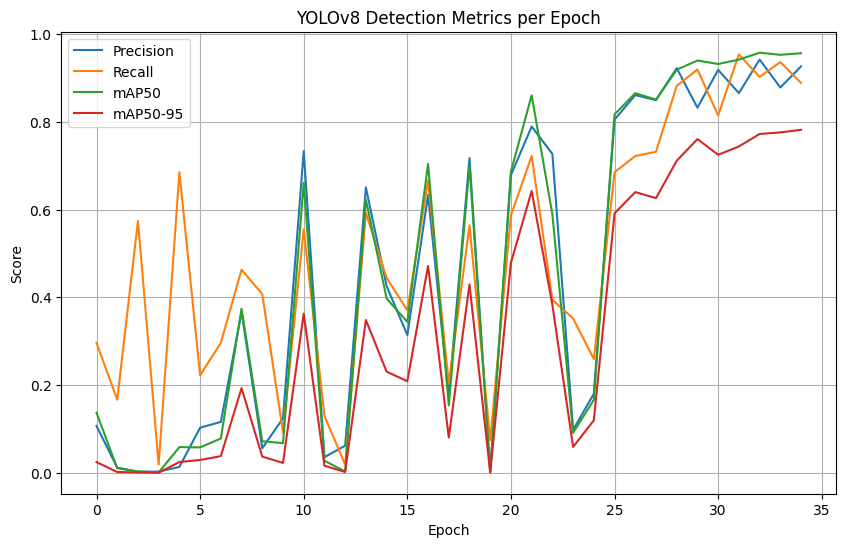

In [12]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now, try plotting again
plt.figure(figsize=(10,6))
plt.plot(df['metrics/precision(B)'], label='Precision')
plt.plot(df['metrics/recall(B)'], label='Recall')
plt.plot(df['metrics/mAP50(B)'], label='mAP50')
plt.plot(df['metrics/mAP50-95(B)'], label='mAP50-95')
plt.title("YOLOv8 Detection Metrics per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

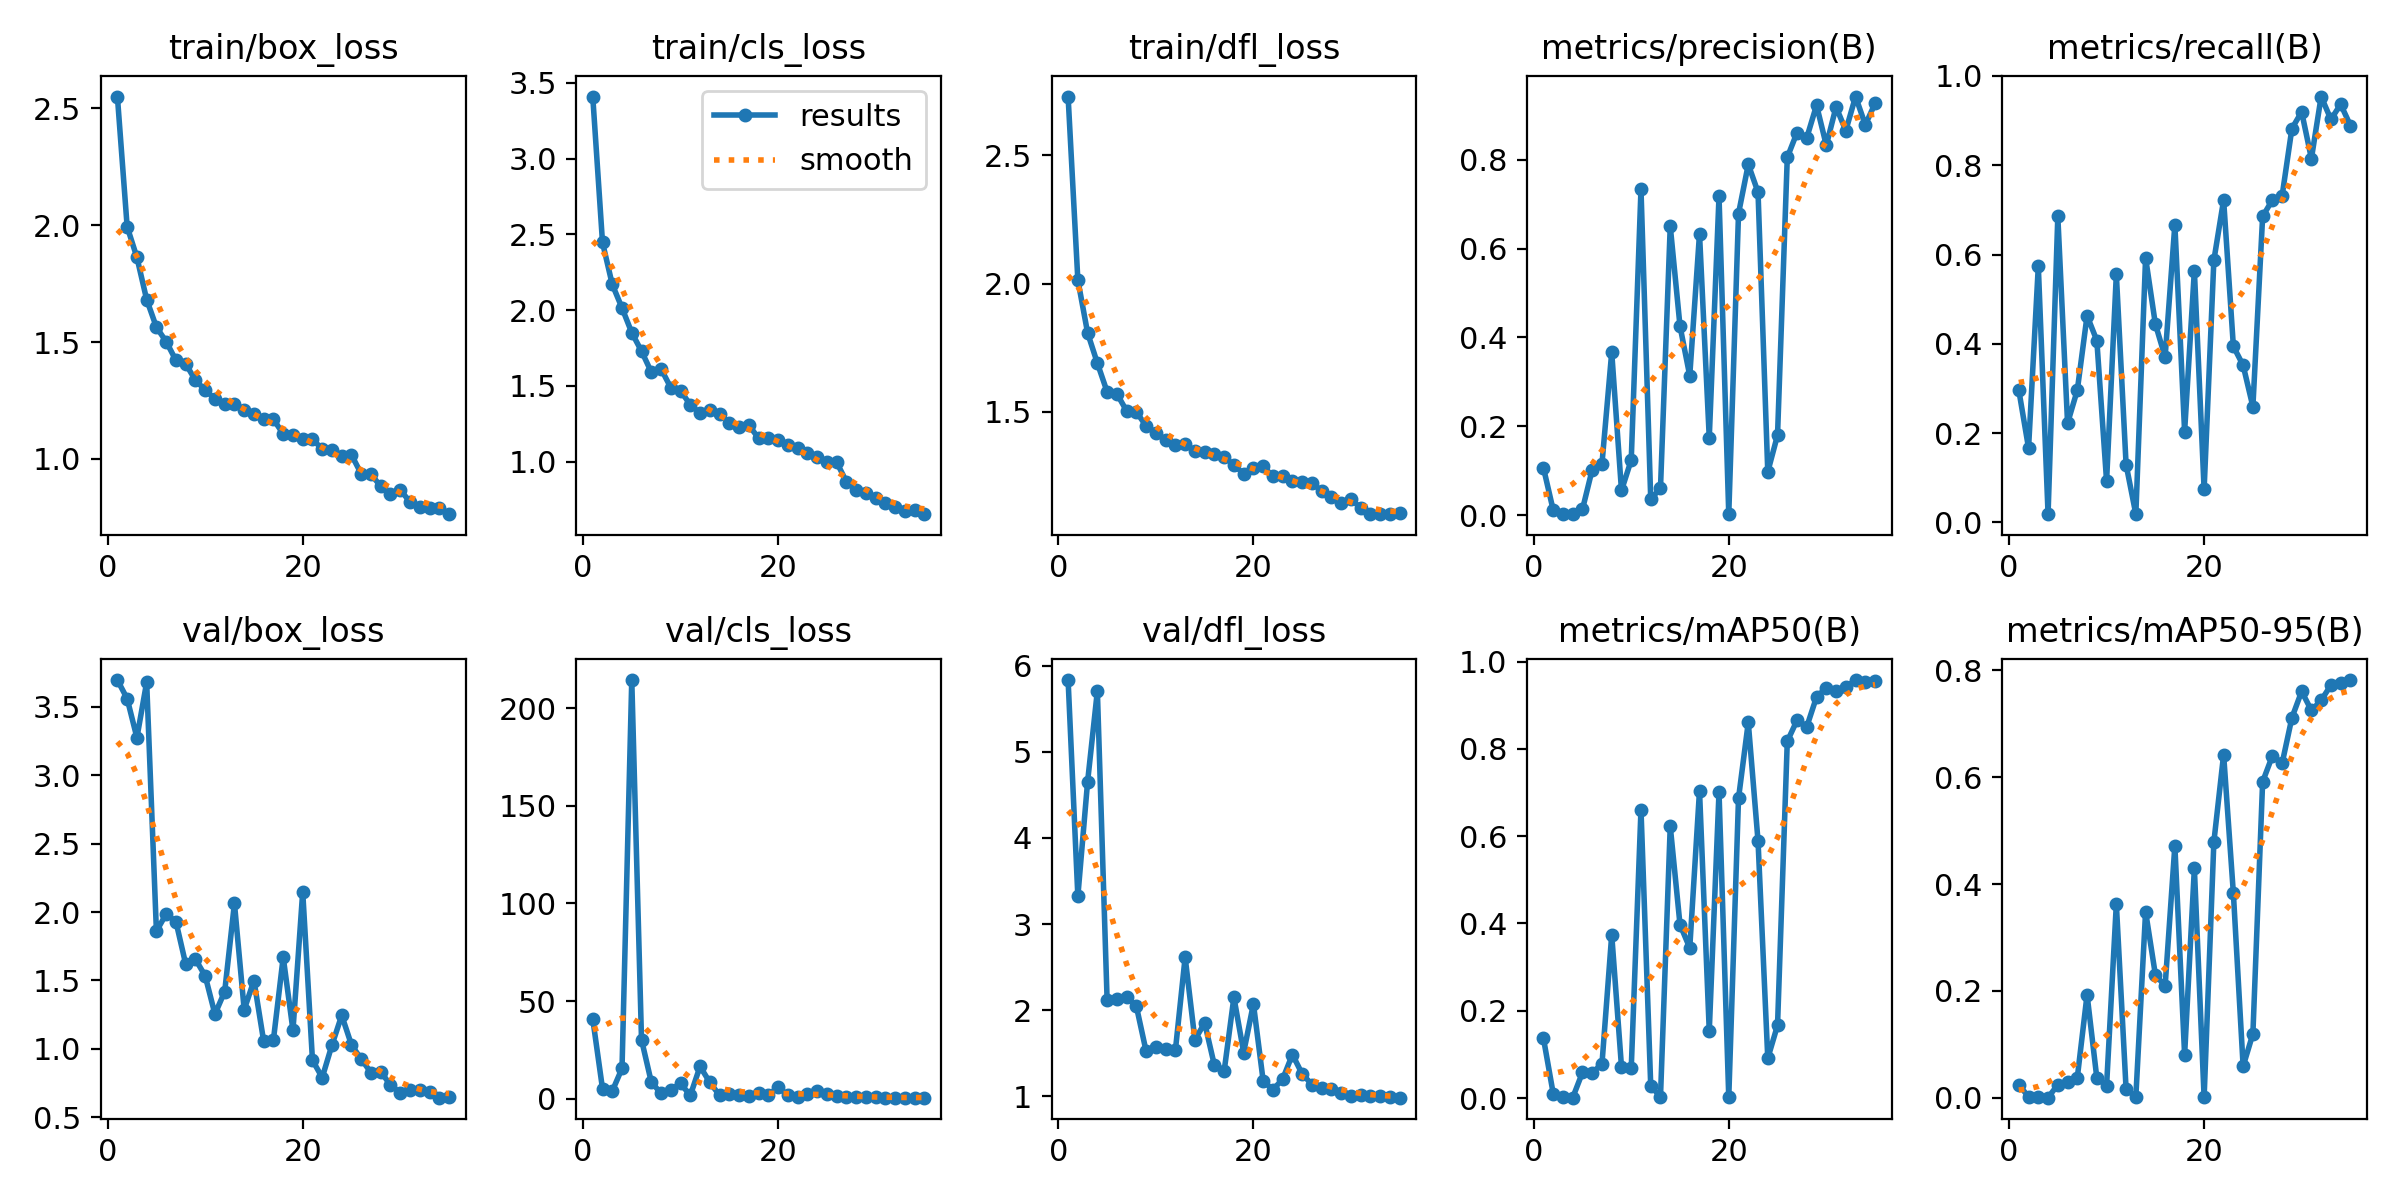

In [13]:
from PIL import Image
from IPython.display import display

img = Image.open("/kaggle/working/runs/detect/train/results.png")
display(img)

In [14]:
from ultralytics import YOLO

model = YOLO("/kaggle/working/runs/detect/train/weights/best.pt")


0: 640x640 2 tables, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


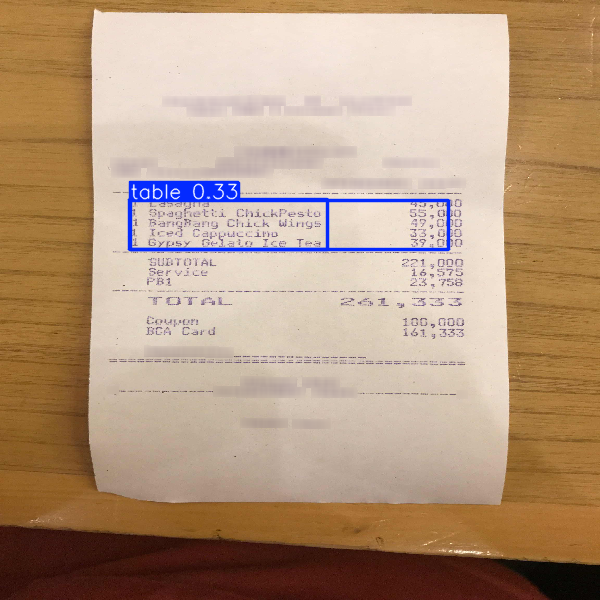

In [15]:
import cv2
import numpy as np

dataset = load_dataset("naver-clova-ix/cord-v2", split="train")
image_path = dataset[5]['image']  # Sudah dalam bentuk PIL.Image
image_np = cv2.cvtColor(np.array(image_path), cv2.COLOR_RGB2BGR)
image_resized = cv2.resize(image_np, (600, 600))

results = model(image_resized)  # Ganti dengan path gambar kamu


# Tampilkan hasilnya
results[0].show()

In [16]:
for result in results:
    boxes = result.boxes  # bounding boxes
    probs = result.probs  # klasifikasi probabilitas (jika ada)
    print(boxes.xyxy)     # koordinat [x1, y1, x2, y2]
    print(boxes.conf)     # confidence score
    print(boxes.cls)      # class index

tensor([[130.3850, 200.0332, 448.4842, 249.5492],
        [129.0840, 199.3480, 327.2855, 249.1426]], device='cuda:0')
tensor([0.3281, 0.3246], device='cuda:0')
tensor([0., 0.], device='cuda:0')


In [17]:
for box in results[0].boxes:
    print(box.xyxy, box.conf, box.cls)

tensor([[130.3850, 200.0332, 448.4842, 249.5492]], device='cuda:0') tensor([0.3281], device='cuda:0') tensor([0.], device='cuda:0')
tensor([[129.0840, 199.3480, 327.2855, 249.1426]], device='cuda:0') tensor([0.3246], device='cuda:0') tensor([0.], device='cuda:0')
